In [1]:
# Import necessary modules for this notebook
import numpy as np

import qiskit
import time
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_bloch_multivector, plot_state_qsphere
from qiskit_aer import AerSimulator
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.visualization import plot_histogram
from qiskit.qasm2 import dumps
print(qiskit.__version__)

2.1.0


In [2]:
import importlib
import sys
from pathlib import Path

PROJECT_ROOT = str(Path.cwd().parent.resolve())
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

import templates as tm

importlib.reload(tm)


<module 'templates' from '/Users/giovanniconcheri/Desktop/WoQ_Qiskit_Hackathon/templates.py'>

Let us create 6-qubit circuit with toffoli sequence

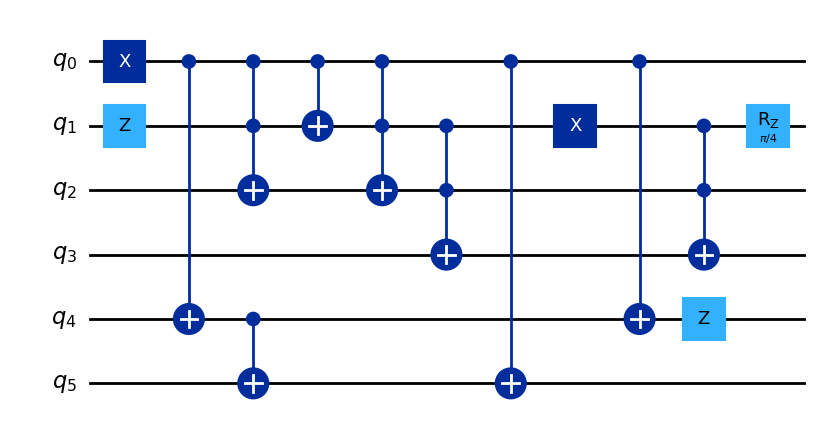

In [4]:
# we create an example of a circuit in which inside there is a template of the database

qc = QuantumCircuit(6)

qc.x(0)
# qc.ccx(4,3,1)
qc.cx(0, 4)
qc.z(1)
qc.ccx(1,0,2)
qc.cx(0, 1)
qc.ccx(0,1,2)
qc.cx(4,5)
qc.ccx(1,2,3)
qc.x(1)
qc.cx(0, 5)
qc.ccx(1, 2, 3)
qc.cx(0, 4)
qc.rz(np.pi/4, 1)
qc.z(4)


qc.draw("mpl")


In [5]:
qc_string = dumps(qc)
qc_list, qubit_num = tm.string_to_list(qc_string)

Optimization level: 0
Transpilation time (sec.): 0.011610031127929688
Circuit depth: 476
------------------------------------------------------------------------------------------------------------------------------------------------------
Optimization level: 1
Transpilation time (sec.): 0.008706092834472656
Circuit depth: 246
------------------------------------------------------------------------------------------------------------------------------------------------------
Optimization level: 2
Transpilation time (sec.): 0.007792949676513672
Circuit depth: 230
------------------------------------------------------------------------------------------------------------------------------------------------------
Optimization level: 3
Transpilation time (sec.): 0.012119770050048828
Circuit depth: 247
------------------------------------------------------------------------------------------------------------------------------------------------------


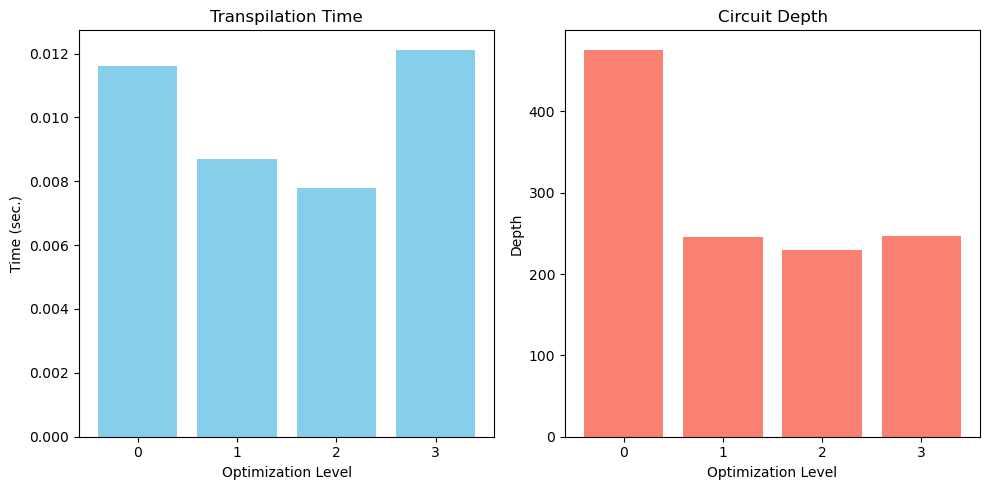

In [79]:
tm.plot_circuitdepth("FakeSherbrooke",qc)


In [7]:
print("3_2: ", tm.find_3_2(qc_list))
print("4_2: ", tm.find_4_2(qc_list))
print("4_3: ", tm.find_4_3(qc_list))

3_2:  ([[6, 9, 11]], [['cx', 0, 4], ['cx', 4, 5]])
4_2:  ([[3, 4, 5]], [['cx', 0, 1], ['cx', 0, 2]])
4_3:  ([[7, 8, 10]], [['x', 1], ['cx', 2, 3]])


In [8]:
new_qc = tm.construct_newcircuit(qc)

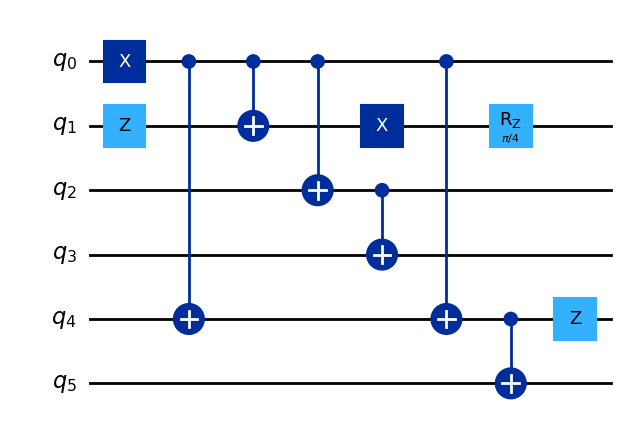

In [9]:
new_qc.draw("mpl")

Optimization level: 0
Transpilation time (sec.): 0.004759073257446289
Circuit depth: 136
------------------------------------------------------------------------------------------------------------------------------------------------------
Optimization level: 1
Transpilation time (sec.): 0.0042760372161865234
Circuit depth: 69
------------------------------------------------------------------------------------------------------------------------------------------------------
Optimization level: 2
Transpilation time (sec.): 0.004420042037963867
Circuit depth: 65
------------------------------------------------------------------------------------------------------------------------------------------------------
Optimization level: 3
Transpilation time (sec.): 0.008295774459838867
Circuit depth: 52
------------------------------------------------------------------------------------------------------------------------------------------------------


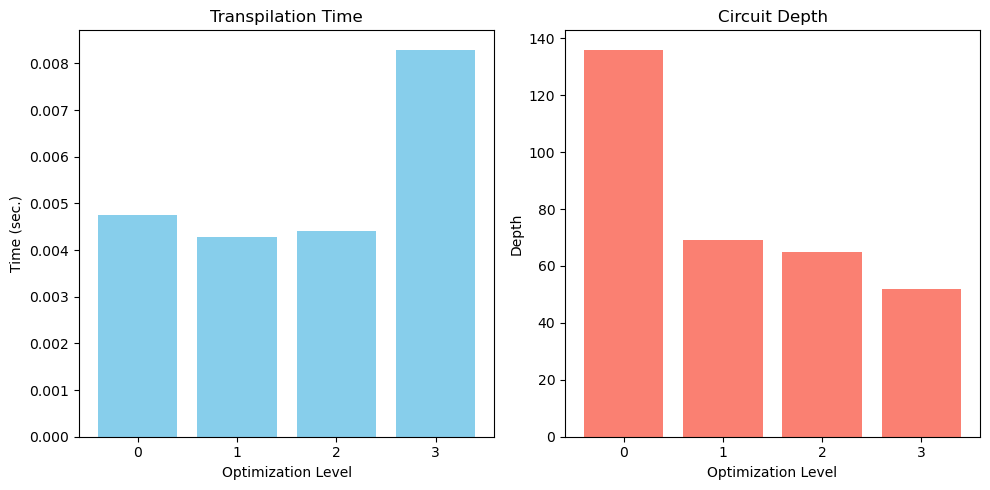

In [80]:
tm.plot_circuitdepth("FakeSherbrooke",new_qc)


## Error comparison

In [61]:
# ZZII...II, ZIZI...II, ... , ZIII...IZ
n = int(qubit_num)  # Number of qubits

operator_strings_Z = ["Z" + i * "I" + "Z" + "I" * (n - i - 2) for i in range(n - 1)]
# operator_strings_X = ["X" + i * "I" + "X" + "I" * (n - i - 2) for i in range(n - 1)]

operators = [SparsePauliOp(operator) for operator in operator_strings_Z] # [SparsePauliOp(operator) for operator in operator_strings_X]

Naive quantum circuit (error)

In [62]:
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke
backend = FakeSherbrooke()

# Create an Estimator instance
estimator = Estimator(mode=backend)
estimator.options.resilience_level = 1
estimator.options.default_shots = 5000

In [63]:
pm = generate_preset_pass_manager(backend=backend, optimization_level=2)
isa_circuit = pm.run(qc) 

isa_operators_list = [operator.apply_layout(isa_circuit.layout) for operator in operators]
# Submit the circuit to Estimator
job_1_err = estimator.run([(isa_circuit, isa_operators_list)])
job_id1 = job_1_err.job_id()

# data
data = list(range(1, len(operators) + 1))  # Distance between the Z operators
result_1_err = job_1_err.result()[0]
values_1_err = result_1_err.data.evs  # Expectation value at each Z operator.
values_1_err = [
    np.abs(v / values_1_err[0]) for v in values_1_err
]  # Normalize the expectation values to evaluate how they decay with distance.

In [64]:
pm = generate_preset_pass_manager(backend=backend, optimization_level=2)
isa_circuit = pm.run(new_qc) 

# Submit the circuit to Estimator
job_2_err = estimator.run([(isa_circuit, isa_operators_list)])
job_id_2= job_2_err.job_id()

# data
result_2_err = job_2_err.result()[0]
values_2_err = result_2_err.data.evs  # Expectation value at each Z operator.
values_2_err = [
    np.abs(v / values_2_err[0]) for v in values_2_err
]  # Normalize the expectation values to evaluate how they decay with distance.

/Users/giovanniconcheri/miniconda3/envs/QiskitHackathon/lib/python3.13/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


In [65]:
from qiskit_aer import AerSimulator
from qiskit import transpile
# Create a local simulator backend
backend = AerSimulator()

# Create an Estimator instance
estimator = Estimator(mode=backend)
estimator.options.resilience_level = 1
estimator.options.default_shots = 5000

In [66]:
# pm = generate_preset_pass_manager(backend=backend, optimization_level=2)
# isa_circuit = pm.run(qc) 

# transpiled_circuit = transpile(isa_circuit, backend=estimator._backend)

# # recupera il layout dalla versione prima della transpile
# layout = isa_circuit.layout  # contiene la mappatura logica → fisica

# isa_operators_list = [operator.apply_layout(isa_circuit.layout) for operator in operators]
# # Submit the circuit to Estimator
# job_1 = estimator.run([(transpiled_circuit, isa_operators_list)])
# job_id1 = job_1.job_id()

# # data
# data = list(range(1, len(operators) + 1))  # Distance between the Z operators
# result_1 = job_1.result()[0]
# values_1 = result_1.data.evs  # Expectation value at each Z operator.
# values_1 = [
#     np.abs(v / values_1[0]) for v in values_1
# ]  # Normalize the expectation values to evaluate how they decay with distance.

pm = generate_preset_pass_manager(backend=backend, optimization_level=2)
isa_circuit = pm.run(qc) 

isa_operators_list = [operator.apply_layout(isa_circuit.layout) for operator in operators]
# Submit the circuit to Estimator
job_1 = estimator.run([(isa_circuit, isa_operators_list)])
job_id1 = job_1.job_id()

# data
data = list(range(1, len(operators) + 1))  # Distance between the Z operators
result_1 = job_1.result()[0]
values_1 = result_1.data.evs  # Expectation value at each Z operator.
values_1 = [
    np.abs(v / values_1[0]) for v in values_1
]  # Normalize the expectation values to evaluate how they decay with distance.

/Users/giovanniconcheri/miniconda3/envs/QiskitHackathon/lib/python3.13/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:187: UserWarning: The resilience_level option has no effect in local testing mode.
  warnings.warn("The resilience_level option has no effect in local testing mode.")


In [67]:
pm = generate_preset_pass_manager(backend=backend, optimization_level=2)
isa_circuit = pm.run(new_qc) 
isa_operators_list = [operator.apply_layout(isa_circuit.layout) for operator in operators]
# Submit the circuit to Estimator
job_2 = estimator.run([(isa_circuit, isa_operators_list)])
job_id_2 = job_2.job_id()

# data
result_2 = job_2.result()[0]
values_2 = result_2.data.evs  # Expectation value at each Z operator.
values_2 = [
    np.abs(v / values_2[0]) for v in values_2
]  # Normalize the expectation values to evaluate how they decay with distance.

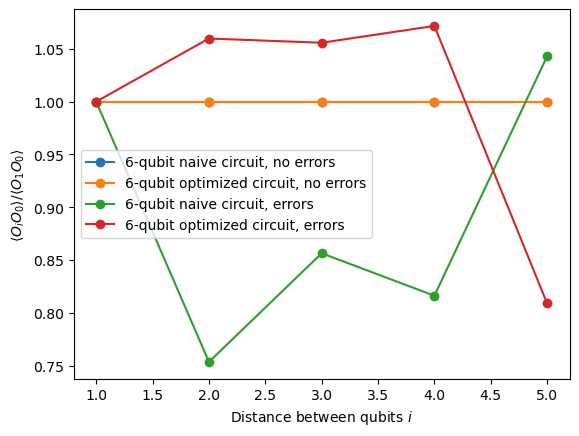

In [ ]:
# plotting graph
plt.plot(data, values_1, marker="o", label=f"{n}-qubit naive circuit, no errors")
plt.plot(data, values_2, marker="o", label=f"{n}-qubit optimized circuit, no errors")
plt.plot(data, values_1_err, marker="o", label=f"{n}-qubit naive circuit, errors")
plt.plot(data, values_2_err, marker="o", label=f"{n}-qubit optimized circuit, errors")
plt.xlabel("Distance between qubits $i$")
plt.ylabel(r"$\langle Z_i Z_0 \rangle / \langle Z_1 Z_0 \rangle $")
plt.legend()
plt.show()

Optimization level: 0
Transpilation time (sec.): 0.008828878402709961
Circuit depth: 428
------------------------------------------------------------------------------------------------------------------------------------------------------
Optimization level: 1
Transpilation time (sec.): 0.006646156311035156
Circuit depth: 246
------------------------------------------------------------------------------------------------------------------------------------------------------
Optimization level: 2
Transpilation time (sec.): 0.008099794387817383
Circuit depth: 247
------------------------------------------------------------------------------------------------------------------------------------------------------
Optimization level: 3
Transpilation time (sec.): 0.01241302490234375
Circuit depth: 233
------------------------------------------------------------------------------------------------------------------------------------------------------


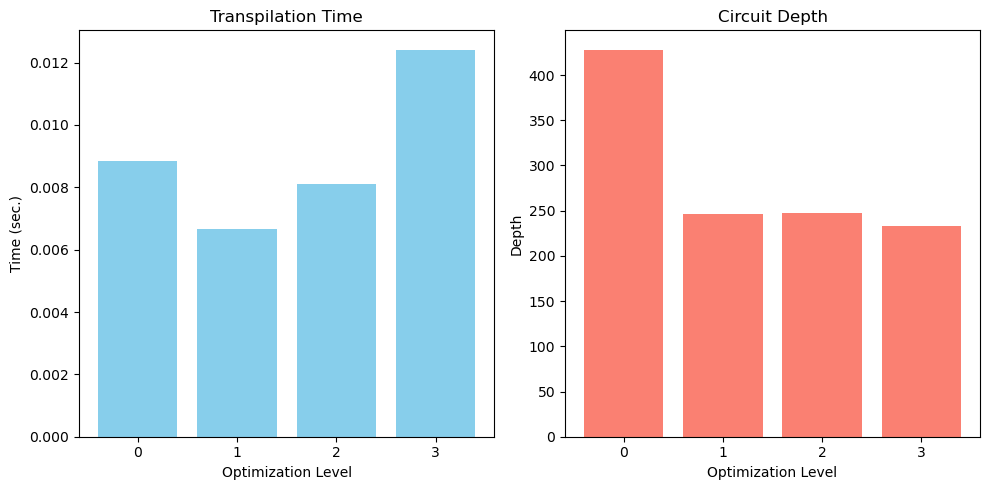

In [78]:
tm.plot_circuitdepth("FakeSherbrooke", qc)